# A rough look in personal investment strategies in US Equities

In [1]:
%matplotlib inline
import yfinance as yf
import pandas as pd

### Example data retrieval

In [247]:
ticker = yf.Ticker("MSFT")
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
hist_df = ticker.history(period="5y")
hist_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-06-09,41.41,41.58,41.14,41.31,24406100,0.0,0
2015-06-10,41.44,42.38,41.35,42.18,28417400,0.0,0
2015-06-11,42.23,42.46,41.75,42.03,27347800,0.0,0
2015-06-12,41.83,42.06,41.54,41.60,23931000,0.0,0
2015-06-15,41.13,41.31,40.74,41.16,33254500,0.0,0


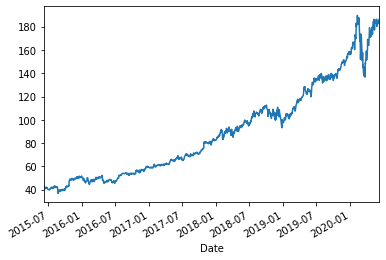

In [248]:
hist_df['Open'].plot()

In [249]:
ticker.dividends.head()

Date
2015-08-18    0.31
2015-11-17    0.36
2016-02-16    0.36
2016-05-17    0.36
2016-08-16    0.36
Name: Dividends, dtype: float64

In [250]:
ticker.recommendations.tail()

,Firm,To Grade,From Grade,Action
Date,,,,
2020-04-30 13:15:42,Credit Suisse,Outperform,,main
2020-04-30 13:42:14,UBS,Buy,,main
2020-04-30 14:21:15,BMO Capital,Outperform,,main
2020-04-30 15:47:20,Wells Fargo,Overweight,,main
2020-05-18 13:45:46,RBC Capital,Outperform,,reit


In [153]:
# Setup
# SP500, Russell 2000, total stock market, REIT, Amazon, Google, Microsoft, Apple
ticker_names = ['VOO', 'VTWO', 'VTSMX', 'VNQ', 'AMZN', 'GOOGL', 'MSFT', 'AAPL']
tickers = [yf.Ticker(t) for t in ticker_names]

period = 'max'

In [154]:
data_df = [t.history(period=period) for t in tickers]
first_date_all_available = max([df.iloc[0].name for df in data_df])
print("first date where all tickers have data: {}".format(first_date_all_available))

first date where all tickers have data: 2010-09-22 00:00:00


In [155]:
# merge into one df (not used)
from functools import reduce
data_df_suffix = [data_df[i].add_suffix(ticker_names[i]) for i in range(len(ticker_names))]
merged_df = pd.concat(data_df_suffix, axis=1, join='inner')
merged_df.head()

,OpenVOO,HighVOO,LowVOO,CloseVOO,VolumeVOO,DividendsVOO,Stock SplitsVOO,OpenVTWO,HighVTWO,LowVTWO,...,VolumeMSFT,DividendsMSFT,Stock SplitsMSFT,OpenAAPL,HighAAPL,LowAAPL,CloseAAPL,VolumeAAPL,DividendsAAPL,Stock SplitsAAPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-22,85.80,86.20,85.31,85.47,18100,0.000,0.0,46.74,46.76,45.97,...,94299400,0.0,0.0,34.96,35.61,34.93,35.59,146322400,0.0,0.0
2010-09-23,84.79,85.62,84.62,84.77,33300,0.000,0.0,45.58,46.31,45.40,...,46201800,0.0,0.0,35.41,36.21,35.37,35.73,196529200,0.0,0.0
2010-09-24,85.76,86.55,85.69,86.50,24100,0.558,0.0,46.20,46.93,46.13,...,51948800,0.0,0.0,36.12,36.30,35.93,36.15,162372000,0.0,0.0
2010-09-27,86.62,86.62,86.09,86.09,15000,0.000,0.0,47.32,47.32,46.70,...,43603300,0.0,0.0,36.36,36.45,35.99,36.01,120708700,0.0,0.0
2010-09-28,86.07,86.65,85.33,86.65,49800,0.000,0.0,46.41,47.43,46.25,...,56041200,0.0,0.0,36.08,36.08,34.01,35.48,258760600,0.0,0.0


In [175]:
# Start date
import dateutil

first_date = dateutil.parser.parse("2016-01-04")
last_date = dateutil.parser.parse("2020-06-05")

daily_notional = 200

### Simple dollar cost averaging

This tries to answer the question: had we bought only SP500 / world stock index / certain sectors using DCA everyday / first day of month / middle of the month in the last specified number of years, what the return would have looked like.

##### Daily DCA, dividends are not reinvested.

In [243]:
data_df_filtered = [d[(d.index >= first_date) & (d.index <= last_date)] for d in data_df]

for i in range(len(data_df_filtered)):
    data_df_filtered[i].loc[:, 'add_shares'] = daily_notional / data_df_filtered[i]['Open']
    data_df_filtered[i].loc[:, 'add_shares_cumsum'] = data_df_filtered[i]['add_shares'].cumsum()
    data_df_filtered[i].loc[:, 'add_dividends'] = data_df_filtered[i]['add_shares_cumsum'] * data_df_filtered[i]['Dividends']

total_shares = {ticker_names[i]: {
    "total_add_shares": data_df_filtered[i]['add_shares'].sum(),
    "total_dividends": data_df_filtered[i]['add_dividends'].sum(),
    "first_opening_price": data_df_filtered[i].iloc[0]["Open"],
    "last_closing_price": data_df_filtered[i].iloc[-1]["Close"],
    "trading_days": len(data_df_filtered[i].index),
    "total_investment_notional": daily_notional * len(data_df_filtered[i].index),
} for i in range(len(ticker_names))}

summary_df = pd.DataFrame.from_dict(total_shares).transpose()

summary_df['total_end_notional'] = summary_df['total_add_shares'] * summary_df['last_closing_price']
summary_df['total_end_value'] = summary_df['total_dividends'] + summary_df['total_end_notional']
summary_df['total_return'] = summary_df['total_end_value'] / summary_df['total_investment_notional']
# If you have all the money on day 1
summary_df['baseline_return'] = summary_df['last_closing_price'] / summary_df['first_opening_price']
summary_df


,total_add_shares,total_dividends,first_opening_price,last_closing_price,trading_days,total_investment_notional,total_end_notional,total_end_value,total_return,baseline_return
VOO,999.779221,11547.360272,168.91,293.61,1114.0,222800.0,293545.177115,305092.537387,1.369356,1.738263
VTWO,2046.952379,7209.403837,83.86,120.86,1114.0,222800.0,247394.664479,254604.068316,1.142747,1.441212
VTSMX,3669.261791,10339.781464,46.30,78.81,1114.0,222800.0,289174.521714,299514.303178,1.344319,1.702160
VNQ,2935.021019,22038.441688,66.18,84.69,1114.0,222800.0,248566.930101,270605.371789,1.214566,1.279692
AMZN,195.595775,0.000000,656.29,2483.00,1114.0,222800.0,485664.308150,485664.308150,2.179822,3.783388
GOOGL,223.679331,0.000000,762.20,1440.02,1114.0,222800.0,322102.710880,322102.710880,1.445703,1.889294
MSFT,2765.488080,13806.264836,49.82,187.20,1114.0,222800.0,517699.368634,531505.633470,2.385573,3.757527
AAPL,1469.601492,11300.839520,95.40,331.50,1114.0,222800.0,487172.894509,498473.734029,2.237315,3.474843


##### Daily DCA with dividends immediately reinvested

If **dividends** are immediately reinvested, how much does that change the answer?

(and to fairly account for dividends, REIT is taxed at a different rate than others (?))

In [244]:
data_df_filtered = [d[(d.index >= first_date) & (d.index <= last_date)] for d in data_df]

for i in range(len(data_df_filtered)):
    data_df_filtered[i].loc[:, 'adjusted_add_notional'] = daily_notional
    data_df_filtered[i].loc[:, 'add_shares_cumsum'] = 0
    data_df_filtered[i].loc[:, 'add_shares'] = daily_notional / data_df_filtered[i].iloc[j]['Open']
    
    # this iteration is unideal, but I didn't find an alternative given the dependent nature of dividends calc
    for j in range(1, len(data_df_filtered[i].index)):
        # note when assigning by iloc and column-name, indexing first by column-name works
        # https://stats.stackexchange.com/questions/283572/using-iloc-to-set-values/283575
        data_df_filtered[i]['adjusted_add_notional'].iloc[j] += data_df_filtered[i]['Dividends'].iloc[j] * data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1]
        data_df_filtered[i]['add_shares'].iloc[j] = data_df_filtered[i]['adjusted_add_notional'].iloc[j] / data_df_filtered[i]['Close'].iloc[j]
        data_df_filtered[i]['add_shares_cumsum'].iloc[j] = data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1] + data_df_filtered[i]['add_shares'].iloc[j]
        
total_shares = {ticker_names[i]: {
    "total_add_shares": data_df_filtered[i]['add_shares'].sum(),
    "first_opening_price": data_df_filtered[i].iloc[0]["Open"],
    "last_closing_price": data_df_filtered[i].iloc[-1]["Close"],
    "trading_days": len(data_df_filtered[i].index),
    "total_investment_notional": daily_notional * len(data_df_filtered[i].index)
} for i in range(len(ticker_names))}

summary_df = pd.DataFrame.from_dict(total_shares).transpose()

summary_df['total_end_value'] = summary_df['total_add_shares'] * summary_df['last_closing_price']
summary_df['total_return'] = summary_df['total_end_value'] / summary_df['total_investment_notional']
summary_df['baseline_return'] = summary_df['last_closing_price'] / summary_df['first_opening_price']
summary_df

/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,total_add_shares,first_opening_price,last_closing_price,trading_days,total_investment_notional,total_end_value,total_return,baseline_return
VOO,1047.350359,168.91,293.61,1114.0,222800.0,307512.538760,1.380218,1.738263
VTWO,2108.326775,83.86,120.86,1114.0,222800.0,254812.374086,1.143682,1.441212
VTSMX,3829.299596,46.30,78.81,1114.0,222800.0,301787.101133,1.354520,1.702160
VNQ,3229.322342,66.18,84.69,1114.0,222800.0,273491.309183,1.227519,1.279692
AMZN,195.370504,656.29,2483.00,1114.0,222800.0,485104.962279,2.177311,3.783388
GOOGL,223.532567,762.20,1440.02,1114.0,222800.0,321891.367059,1.444755,1.889294
MSFT,2897.350329,49.82,187.20,1114.0,222800.0,542383.981623,2.434398,3.757527
AAPL,1526.987054,95.40,331.50,1114.0,222800.0,506196.208411,2.271976,3.474843


Immediate reinvestment of dividends seems to generate an additional 2 - 4% over 4 years.

##### Monthly DCA with dividends reinvestment

In [245]:
data_df_filtered = [d[(d.index >= first_date) & (d.index <= last_date)] for d in data_df]

# first day handling was problematic in the loop below
picked_dates = list(data_df_filtered[0].index[1::22])
# invest on the last day for fairness
picked_dates.append(data_df_filtered[0].index[-1])

for i in range(len(data_df_filtered)):
    data_df_filtered[i].loc[:, 'adjusted_add_notional'] = 0
    data_df_filtered[i].loc[:, 'add_shares_cumsum'] = 0
    data_df_filtered[i].loc[:, 'add_shares'] = 0
    
    date_idx = 0
    accumulated_investment_notional = 0
    # this iteration is unideal, but I didn't find an alternative given the dependent nature of dividends calc
    for j in range(1, len(data_df_filtered[i].index)):
        if picked_dates[date_idx] == data_df_filtered[i].index[j]:
            data_df_filtered[i]['adjusted_add_notional'].iloc[j] = accumulated_investment_notional
            data_df_filtered[i]['add_shares'].iloc[j] = data_df_filtered[i]['adjusted_add_notional'].iloc[j] / data_df_filtered[i]['Close'].iloc[j]
            data_df_filtered[i]['add_shares_cumsum'].iloc[j] = data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1] + data_df_filtered[i]['add_shares'].iloc[j]
            accumulated_investment_notional = 0
            date_idx += 1
        else:
            accumulated_investment_notional += daily_notional
            accumulated_investment_notional += data_df_filtered[i]['Dividends'].iloc[j] * data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1]
            data_df_filtered[i]['add_shares_cumsum'].iloc[j] = data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1]
    
total_shares = {ticker_names[i]: {
    "total_add_shares": data_df_filtered[i]['add_shares'].sum(),
    "first_opening_price": data_df_filtered[i].iloc[0]["Open"],
    "last_closing_price": data_df_filtered[i].iloc[-1]["Close"],
    "trading_days": len(data_df_filtered[i].index),
    "total_investment_notional": daily_notional * len(data_df_filtered[i].index)
} for i in range(len(ticker_names))}

summary_df = pd.DataFrame.from_dict(total_shares).transpose()

summary_df['total_end_value'] = summary_df['total_add_shares'] * summary_df['last_closing_price']
summary_df['total_return'] = summary_df['total_end_value'] / summary_df['total_investment_notional']
summary_df['baseline_return'] = summary_df['last_closing_price'] / summary_df['first_opening_price']
summary_df

/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zhehaowang/Library/Python/3.7/lib/pytho

,total_add_shares,first_opening_price,last_closing_price,trading_days,total_investment_notional,total_end_value,total_return,baseline_return
VOO,994.483226,168.91,293.61,1114.0,222800.0,291990.219874,1.310549,1.738263
VTWO,2006.759081,83.86,120.86,1114.0,222800.0,242536.902576,1.088586,1.441212
VTSMX,3625.029655,46.30,78.81,1114.0,222800.0,285688.587136,1.282265,1.702160
VNQ,3077.417821,66.18,84.69,1114.0,222800.0,260626.515247,1.169778,1.279692
AMZN,185.212409,656.29,2483.00,1114.0,222800.0,459882.411490,2.064104,3.783388
GOOGL,212.807046,762.20,1440.02,1114.0,222800.0,306446.402374,1.375433,1.889294
MSFT,2742.186826,49.82,187.20,1114.0,222800.0,513337.373782,2.304028,3.757527
AAPL,1436.890283,95.40,331.50,1114.0,222800.0,476329.128889,2.137922,3.474843


This is over 10% worse than continuous DCA in most profitable instruments.

### Pretty much random

In [246]:
data_df_filtered = [d[(d.index >= first_date) & (d.index <= last_date)] for d in data_df]

picked_dates = sorted(data_df_filtered[0].sample(n = 5).index)
# invest on the last day for fairness
picked_dates.append(data_df_filtered[0].index[-1])
print(picked_dates)

for i in range(len(data_df_filtered)):
    data_df_filtered[i].loc[:, 'adjusted_add_notional'] = 0
    data_df_filtered[i].loc[:, 'add_shares_cumsum'] = 0
    data_df_filtered[i].loc[:, 'add_shares'] = daily_notional / data_df_filtered[i].iloc[j]['Open']
    
    date_idx = 0
    accumulated_investment_notional = 0
    # this iteration is unideal, but I didn't find an alternative given the dependent nature of dividends calc
    for j in range(1, len(data_df_filtered[i].index)):
        if picked_dates[date_idx] == data_df_filtered[i].index[j]:
            data_df_filtered[i]['adjusted_add_notional'].iloc[j] = accumulated_investment_notional
            data_df_filtered[i]['add_shares'].iloc[j] = data_df_filtered[i]['adjusted_add_notional'].iloc[j] / data_df_filtered[i]['Close'].iloc[j]
            data_df_filtered[i]['add_shares_cumsum'].iloc[j] = data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1] + data_df_filtered[i]['add_shares'].iloc[j]
            accumulated_investment_notional = 0
            date_idx += 1
        else:
            accumulated_investment_notional += daily_notional
            accumulated_investment_notional += data_df_filtered[i]['Dividends'].iloc[j] * data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1]
            data_df_filtered[i]['add_shares'].iloc[j] = 0
            data_df_filtered[i]['add_shares_cumsum'].iloc[j] = data_df_filtered[i]['add_shares_cumsum'].iloc[j - 1]

total_shares = {ticker_names[i]: {
    "total_add_shares": data_df_filtered[i]['add_shares'].sum(),
    "first_opening_price": data_df_filtered[i].iloc[0]["Open"],
    "last_closing_price": data_df_filtered[i].iloc[-1]["Close"],
    "trading_days": len(data_df_filtered[i].index),
    "total_investment_notional": daily_notional * len(data_df_filtered[i].index)
} for i in range(len(ticker_names))}

summary_df = pd.DataFrame.from_dict(total_shares).transpose()

summary_df['total_end_value'] = summary_df['total_add_shares'] * summary_df['last_closing_price']
summary_df['total_return'] = summary_df['total_end_value'] / summary_df['total_investment_notional']
summary_df['baseline_return'] = summary_df['last_closing_price'] / summary_df['first_opening_price']
summary_df

[Timestamp('2017-01-20 00:00:00'), Timestamp('2018-03-02 00:00:00'), Timestamp('2018-05-21 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-12-18 00:00:00'), Timestamp('2020-06-05 00:00:00')]


/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zhehaowang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zhehaowang/Library/Python/3.7/lib/pytho

,total_add_shares,first_opening_price,last_closing_price,trading_days,total_investment_notional,total_end_value,total_return,baseline_return
VOO,963.050047,168.91,293.61,1114.0,222800.0,282761.124373,1.269125,1.738263
VTWO,1933.095192,83.86,120.86,1114.0,222800.0,233633.884936,1.048626,1.441212
VTSMX,3521.512016,46.30,78.81,1114.0,222800.0,277530.361984,1.245648,1.702160
VNQ,3130.864159,66.18,84.69,1114.0,222800.0,265152.885611,1.190094,1.279692
AMZN,164.395235,656.29,2483.00,1114.0,222800.0,408193.367383,1.832107,3.783388
GOOGL,206.074608,762.20,1440.02,1114.0,222800.0,296751.556702,1.331919,1.889294
MSFT,2450.922744,49.82,187.20,1114.0,222800.0,458812.737739,2.059303,3.757527
AAPL,1339.291454,95.40,331.50,1114.0,222800.0,443975.116940,1.992707,3.474843


It would seem pretty much random gets outperformed significantly (>30% difference in return)

### Every down by x% day